In [1]:
import numpy as np 

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda import stream
from torch.nn.utils.rnn import pad_sequence
from torch_geometric.data import Batch
from torch_geometric.nn import GCNConv, MetaLayer
from torch_scatter import scatter_mean

class PerceptionNetwork(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(4, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        fc_size = 16*(((((800-4)/2)-4)/2)**2)
        fc_size = int(fc_size)
        self.fc1 = nn.Linear(fc_size, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 64)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) #620944
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x 


In [3]:
def get_perception(perception_raw):
    # import matplotlib.pyplot as plt 
    # plt.subplot(121)
    # plt.imshow(problem_info.perception['color'])
    # plt.title('Color image')
    # plt.subplot(122)
    # plt.imshow(np.squeeze(problem_info.perception['depth']))
    # plt.title('Depth image')
    # plt.savefig('/home/alex/drake-tamp/learning/gnn/test_rgbd_0.png')
    
    #TODO do clipping and normalization
    from numpy import inf 
    #the 4th channel is alpha we don't care 
    col = perception_raw['color'][:, :, :3]
    dep = perception_raw['depth'][:, :, ]

    #change everything at infinite distance to just be the ground 
    dep[dep == inf] = np.max(dep[dep < 1000])

    #stack the depth and rgb data
    perception = torch.from_numpy(np.concatenate((col, dep), axis=2))

    #normalizing
    input = torch.reshape(perception, (640000, 4))
    means = torch.mean(input, axis=0)
    std = torch.std(input, dim=0)
    normalized = (input - means)/std
    input = torch.reshape(normalized, (800, 800, 4))

    #reshaping to NCWH format for convolution 
    perception = input.permute(2, 0, 1)
    perception = perception.reshape([1, 4, 800, 800])
    perception = torch.nn.functional.interpolate(perception, (200, 200))
    return perception

In [4]:
import pickle

pik_file = "/home/alex/drake-tamp/experiments/jobs/clutter/train/oracle/5_10_3_13.yaml_logs/2022-07-07-18:59:29.921_labels.pkl" 
with open(pik_file, "rb") as file:
    data = pickle.load(file)



perception = get_perception(data['problem_info'].perception )


torch.Size([1, 4, 200, 200])


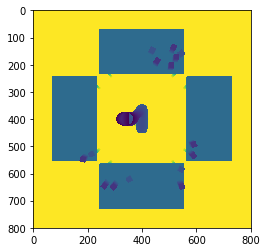

In [5]:
import matplotlib.pyplot as plt
# small = torch.nn.functional.interpolate(perception, (200, 200))

print(perception.shape)

plt.imshow(np.squeeze(data['problem_info'].perception['depth'], axis=2))
plt.show()

In [123]:
data['problem_info'].model_poses

[{'X': <panda_station.utils.RigidTransformWrapper at 0x7fc0ffce15c0>,
  'name': 'block0',
  'static': False},
 {'X': <panda_station.utils.RigidTransformWrapper at 0x7fc0ffce17b8>,
  'name': 'block1',
  'static': False},
 {'X': <panda_station.utils.RigidTransformWrapper at 0x7fc2862b9278>,
  'name': 'block2',
  'static': False},
 {'X': <panda_station.utils.RigidTransformWrapper at 0x7fc2862b9780>,
  'name': 'block3',
  'static': False},
 {'X': <panda_station.utils.RigidTransformWrapper at 0x7fc2862b99b0>,
  'name': 'block4',
  'static': False},
 {'X': <panda_station.utils.RigidTransformWrapper at 0x7fc2862b9b38>,
  'name': 'blocker0',
  'static': False},
 {'X': <panda_station.utils.RigidTransformWrapper at 0x7fc2862b9ba8>,
  'name': 'blocker1',
  'static': False},
 {'X': <panda_station.utils.RigidTransformWrapper at 0x7fc2862b9f28>,
  'name': 'blocker2',
  'static': False},
 {'X': <panda_station.utils.RigidTransformWrapper at 0x7fc0e5709198>,
  'name': 'blocker3',
  'static': False},
 {

In [129]:
from math import pi, tan

z_cam = 2 
problem_info = data['problem_info']
(x, y, z) = problem_info.model_poses[4]['X'].rigid_transform.translation()
# z = problem_info.model_poses[0]['X'].rigid_transform.translation()[2]
# x = problem_info.model_poses[0]['X'].rigid_transform.translation()[0]
# y = problem_info.model_poses[0]['X'].rigid_transform.translation()[1]
fov = pi/3
w = (z_cam - z)*tan(fov/2)  
w_pix = 800
x_portion = x/w
y_portion = y/w 
print(x, y, z)
coords = (x_portion, -y_portion)

-0.43826505345437083 -0.3061960360808463 0.3249999063789905


proportional coords: (-0.45319241632031565, 0.31662511159728735)
(219, 526)


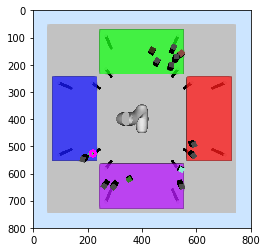

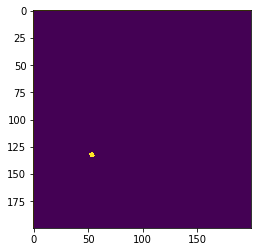

In [130]:
#return mask for object given object coords in image space 
import cv2
def get_object_mask(rgb, coords):
    mask = np.zeros((rgb.shape[0]+2, rgb.shape[1]+2, 1), np.uint8)
    print("proportional coords:", coords)
    coords_abs = (400 + int(coords[0]*(rgb.shape[0]/2)), 400 +int(coords[1]*(rgb.shape[1]/2)))
    #coords_abs = (600, 300)
    circle_image = rgb.copy()
    print(coords_abs)
    cv2.circle(circle_image, coords_abs, 10, (255, 0, 255), 10)
    plt.imshow(circle_image)
    plt.show()
    retval = cv2.floodFill(rgb, mask, coords_abs, (250, 250, 250))
    # plt.imshow(mask.squeeze(axis=2))
    # plt.show()
    m = torch.from_numpy(mask)
    m = m.permute(2, 0, 1)
    m = m.reshape(1, 1, 802, 802)
    m = torch.nn.functional.interpolate(m, (200, 200))
    return m

rgb = data['problem_info'].perception['color'][:, :, :3].copy()
mask = get_object_mask(rgb, coords)

plt.imshow(mask[0][0])
# plt.imshow(rgb)
plt.show()


In [11]:
a = torch.zeros((1, 1, 200, 200))
b = torch.ones((1, 1, 200, 200))
c = torch.cat((a, b), axis=1)
c.shape

torch.Size([1, 2, 200, 200])